# Timeshenko Beam Example

This example is for a beam with a constant applied force. It is similar to an Euler-Bernoulii beam, except it accounts for shear defomation and rotational bending. 

To set up the simulation, the first thing you need to do is import the necessary classes. Here we only import the classes that we need. The `elastica.wrappers` make it easy to construct the systems. Along with these wrappers, we need to import a rod class, classes for the boundary conditions and time-stepping functions. 

In [28]:
import numpy as np
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing
from elastica.rod.cosserat_rod import CosseratRod
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

Now that we have imported all the necessary classes, we need to create our beam system. We do this by combining all the wrappers we need to represent the physics that we want. 

In [29]:
class TimoshenkoBeamSimulator(BaseSystemCollection, Constraints, Forcing):
    pass

timoshenko_sim = TimoshenkoBeamSimulator()

With our simulator set up, we can now define the material properties. The material properties that need to be defined for every rod are the Young's modulus, the poisson ratio, the density and the viscous damping cosfficient. The geometry of the rod also needs to be defined by specifcly the location of the rod, its orientation, length and radius. You also need to define the number of elements in the rod. 

All of the values defined were are done in SI units, though you can rescale values however you want, as long as you are consistent throughout the simulation. 

In [30]:
# setting up test params
n_elem = 100

density = 5e3
nu = 0.1
E = 1e6
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99


start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius ** 2

With all of the rod's parameters set, we can create a rod based on them and add it to the simulator system. 

In [31]:
shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)

timoshenko_sim.append(shearable_rod)

With the rod added to the system, we need to apply boundary conditions. The first condition we will apply is fixing the location of one end of the rod. We do this using the `.constrain()` option and the `OneEndFixedRod` boundary condition. We are modifying the `timoshenko_sim` simulator to `constrain` one of rods `shearable_rod` in it using a particular `OneEndFixedRod` type of constraint. We also need to define which node of the rod is being cosntraint. Here we are fixing the first node in the rod. Finally, to keep the rod from rotating around the fixed point, we need to also constrain an element between two nodes.

In [32]:
timoshenko_sim.constrain(shearable_rod).using(
    OneEndFixedRod, 
    constrained_position_idx=(0,), 
    constrained_director_idx=(0,)
)
print('One of the rod fixed in place')

One of the rod fixed in place


The other boundary condition that we need to apply is the endpoint force. Similarly to how we constrained one of the points, We are modifying the `timoshenko_sim` simulator to `add_forcing_to` the rod `shearable_rod` using a particular `EndpointForces` type of forcing. This `EndpointForces` applies forces to both ends of the rod. Here we want to apply a negative force in the $d_1$ dirction, but only on the far end of the rod. We also want to ramp up the force over time, so we make the force take 20 seconds to reach its steady-state value.

In [33]:
end_force = np.array([-15.0, 0.0, 0.0])

_ = timoshenko_sim.add_forcing_to(shearable_rod).using(
    EndpointForces, 
    0.0*end_force, 
    end_force, 
    ramp_up_time=25.0
)
print('Forces added to the rod')

Forces added to the rod


Along with the shearable rod, we also want to add an unshearable rod to be able to compare the difference between the two. We do this the same way we did for the first rod, however, because this rod is unsherable, we want to change the poisson ratio. 

In [34]:
# Start into the plane
unshearable_start = np.array([0.0, -1.0, 0.0])
unshearable_rod = CosseratRod.straight_rod(
    n_elem,
    unshearable_start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    # Unshearable rod needs G -> inf, which is achievable with -ve poisson ratio
    poisson_ratio=-0.7,
)

timoshenko_sim.append(unshearable_rod)
timoshenko_sim.constrain(unshearable_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

timoshenko_sim.add_forcing_to(unshearable_rod).using(
    EndpointForces, 0.0 * end_force, end_force, ramp_up_time=20.0
)
print('Unshearable rod set up')

Unshearable rod set up


Now we have added all the necessary rods and boundary conditions to our system. The last thing we need to do is finalize the system. This goes through the system and rearranges things to prepare the system for simulation. 

As a note, if you make any. Changes to the rod after calling finalize, you will need to re-finalize the system. 

In [35]:
timoshenko_sim.finalize()
print('System finalized')

System finalized


The last thing we need to do deceide how long we want the simulation to run for and what timestepping method to use. Currently, the PositionVerlet algorithim is suggested default method. 

In [36]:
timestepper = PositionVerlet()

final_time = 50
dl = base_length / n_elem
dt = 0.01 * dl
total_steps = int(final_time / dt)
print("Total steps", total_steps)


Total steps 166666


We are now ready to perform the simulation. To run the simulation, we use `timestepper` to integrate `timoshenko_sim` until `final_time` by taking `total_steps`. The Timoshenk beam simulation takes about 2 minutes to run. 

In [37]:
integrate(timestepper, timoshenko_sim, final_time, total_steps)

100%|██████████| 166666/166666 [02:42<00:00, 1026.06it/s]

Final time of simulation is :  49.999999999834394


Now that we have finished the simulation, we want to post-process the results. We will do this by comparing the solutions for the shearable and unshearable beams with the analytical Timoshenko and Euler-Bernoulii beam results. 

In [38]:
# Compute beam position for sherable and unsherable beams. 
def analytical_result(arg_rod, arg_end_force, shearing=True, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)
    linear_prefactor    = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = -acting_force / 2.0 * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    cubic_prefactor     = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0] 
    if shearing:    
        return arg_s, arg_s*linear_prefactor + arg_s**2*quadratic_prefactor + arg_s**3*cubic_prefactor
    else:
        return arg_s, arg_s**2 * quadratic_prefactor + arg_s**3 * cubic_prefactor

This function plots the elastica results and the analytical results. The one thing to point out is how to access the position of the rods. They are located in `rod.position_collection[dim, n_elem]`. In this case, we are plotting the x- and z-dimensions. 

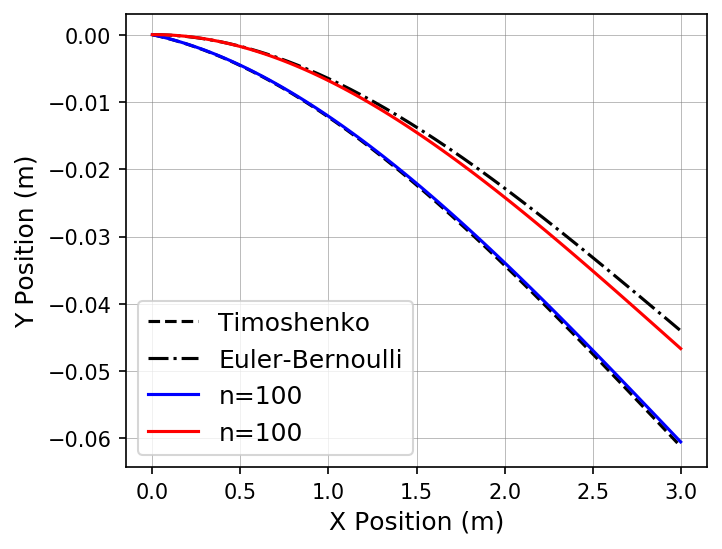

In [39]:
def plot_timoshenko(rod, unshearable_rod, end_force):
    import matplotlib.pyplot as plt
    analytical_shearable_positon = analytical_result(rod, end_force, shearing=True)
    analytical_unshearable_positon = analytical_result(rod, end_force, shearing=False)
    
    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth = 0.25)

    ax.plot(analytical_shearable_positon[0],   analytical_shearable_positon[1],  "k--", label="Timoshenko")
    ax.plot(analytical_unshearable_positon[0], analytical_unshearable_positon[1],"k-.", label="Euler-Bernoulli")
    
    ax.plot(rod.position_collection[2, :], rod.position_collection[0, :], "b-", label="n="+str(rod.n_elems))
    ax.plot(unshearable_rod.position_collection[2, :], 
            unshearable_rod.position_collection[0, :],
            "r-", label="n="+str(rod.n_elems))
    
    ax.legend(prop={"size": 12})
    ax.set_ylabel('Y Position (m)', fontsize = 12)
    ax.set_xlabel('X Position (m)', fontsize = 12)
    plt.show()

# Options
PLOT_FIGURE = True
plot_timoshenko(shearable_rod, unshearable_rod, end_force)